### Importações

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import pingouin as pg

from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import optuna

### EDA - Análise Explorátoria de Dados

In [2]:
# Carregar os dados
df_transacoes = pd.read_csv('./dataset/transacoes_fraude.csv')

In [3]:
df_transacoes.head(15)

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14T07:29:28.256579,0
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12T17:54:09.119410,0
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03T17:31:42.087599,0
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23T17:57:02.055680,0
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07T17:30:36.879557,0
5,cliente62C357,Débito,4848.49,7354.41,2505.92,2025-07-08T19:16:37.207970,0
6,cliente320C76,Crédito,1600.44,7296.87,5696.43,2024-09-07T02:23:16.975044,0
7,cliente32CB58,Crédito,1296.71,10562.92,9266.21,2023-08-28T23:09:19.817457,0
8,cliente67AFD9,Débito,1187.35,10935.18,9747.83,2024-05-21T09:01:08.163132,0
9,cliente84F77D,PIX,3271.51,3405.61,134.10,2022-09-26T10:33:12.415982,0


fraudulenta (1) ou legítima (0)

In [4]:
df_transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cliente                     13000 non-null  object 
 1   Tipo de Transacao           13000 non-null  object 
 2   Valor da Transacao          13000 non-null  float64
 3   Valor Anterior a Transacao  13000 non-null  float64
 4   Valor Apos a Transacao      13000 non-null  float64
 5   Horario da Transacao        13000 non-null  object 
 6   Classe                      13000 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 711.1+ KB


In [5]:
df_transacoes.describe()

,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Classe
count,13000.000000,13000.000000,13000.000000,13000.000000
mean,2511.899952,7547.003386,5035.103435,0.110000
std,1436.446865,3225.212074,2884.967560,0.312902
min,10.000000,95.440000,10.120000,0.000000
25%,1279.412500,5038.805000,2533.727500,0.000000
50%,2525.610000,7538.255000,4997.090000,0.000000
75%,3754.945000,10046.875000,7551.552500,0.000000
max,4999.960000,14897.740000,9999.390000,1.000000


In [6]:
df_transacoes['Tipo de Transacao'].unique()

array(['Saque', 'PIX', 'Débito', 'Crédito'], dtype=object)

In [7]:
value_fraudes = df_transacoes.value_counts('Classe')
value_fraudes

Classe
0    11570
1     1430
Name: count, dtype: int64

In [8]:
lista_classe = [0, 1]

In [9]:
df_transacoes['Hora'] = pd.to_datetime(df_transacoes['Horario da Transacao']).dt.hour
df_transacoes.head()

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe,Hora
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14T07:29:28.256579,0,7
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12T17:54:09.119410,0,17
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03T17:31:42.087599,0,17
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23T17:57:02.055680,0,17
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07T17:30:36.879557,0,17


In [10]:
df_transacoes['Hora'].unique()

array([ 7, 17, 19,  2, 23,  9, 10, 12, 22, 15,  1, 11,  8,  0, 20,  5, 16,
       14, 21,  4, 13,  3, 18,  6], dtype=int32)

In [11]:
df_transacoes_bucketing = df_transacoes.copy()
bins = [0, 6, 12, 18, 24]
labels = ['0-5', '6-11', '12-17', '18-24']
df_transacoes_bucketing['escala_hora'] = pd.cut(x=df_transacoes_bucketing['Hora'], bins=bins, labels=labels, include_lowest=True)
df_transacoes_bucketing.head(10)

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe,Hora,escala_hora
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14T07:29:28.256579,0,7,6-11
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12T17:54:09.119410,0,17,12-17
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03T17:31:42.087599,0,17,12-17
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23T17:57:02.055680,0,17,12-17
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07T17:30:36.879557,0,17,12-17
5,cliente62C357,Débito,4848.49,7354.41,2505.92,2025-07-08T19:16:37.207970,0,19,18-24
6,cliente320C76,Crédito,1600.44,7296.87,5696.43,2024-09-07T02:23:16.975044,0,2,0-5
7,cliente32CB58,Crédito,1296.71,10562.92,9266.21,2023-08-28T23:09:19.817457,0,23,18-24
8,cliente67AFD9,Débito,1187.35,10935.18,9747.83,2024-05-21T09:01:08.163132,0,9,6-11
9,cliente84F77D,PIX,3271.51,3405.61,134.10,2022-09-26T10:33:12.415982,0,10,6-11


In [12]:
crosstab_transacao = pd.crosstab(df_transacoes_bucketing['escala_hora'], df_transacoes['Classe'], margins=True)[lista_classe].reset_index()

tabela_transacao = ff.create_table(crosstab_transacao)
tabela_transacao.show()

In [13]:
# Criando crosstab para saber em quais variaveis as transações falses aparece
# Tipo de transação
crosstab_transacao = pd.crosstab(df_transacoes['Tipo de Transacao'], df_transacoes['Classe'], margins=True)[lista_classe].reset_index()

# tabela de contigencia

tabela_transacao = ff.create_table(crosstab_transacao)
tabela_transacao.show()

In [14]:
df_transacoes_bucketing = df_transacoes.copy()
bins = [-1, 6, 12, 18, 24]
labels = ['Madrugada', 'Manhã', 'Tarde', 'Noite']
df_transacoes_bucketing['escala_hora'] = pd.cut(x=df_transacoes_bucketing['Hora'], bins=bins, labels=labels)
df_transacoes_bucketing.head(10)

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe,Hora,escala_hora
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14T07:29:28.256579,0,7,Manhã
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12T17:54:09.119410,0,17,Tarde
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03T17:31:42.087599,0,17,Tarde
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23T17:57:02.055680,0,17,Tarde
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07T17:30:36.879557,0,17,Tarde
5,cliente62C357,Débito,4848.49,7354.41,2505.92,2025-07-08T19:16:37.207970,0,19,Noite
6,cliente320C76,Crédito,1600.44,7296.87,5696.43,2024-09-07T02:23:16.975044,0,2,Madrugada
7,cliente32CB58,Crédito,1296.71,10562.92,9266.21,2023-08-28T23:09:19.817457,0,23,Noite
8,cliente67AFD9,Débito,1187.35,10935.18,9747.83,2024-05-21T09:01:08.163132,0,9,Manhã
9,cliente84F77D,PIX,3271.51,3405.61,134.10,2022-09-26T10:33:12.415982,0,10,Manhã


In [15]:
crosstab_transacao = pd.crosstab(df_transacoes_bucketing['escala_hora'], df_transacoes['Classe'], margins=True)[lista_classe].reset_index()

tabela_transacao = ff.create_table(crosstab_transacao)
tabela_transacao.show()

In [16]:
# Criando bins e labels par o valor da transacao(bucketing)
df_transacoes_bucketing = df_transacoes.copy()
bins = [10, 625, 1250, 1875, 2500, 3125, 3750, 4375, 5000]
labels = ['10-624', '625-1249', '1250-1874', '1875-2499', '2500-3124', '3125-3749', '3750-4374', '4375-4999']
df_transacoes_bucketing['escala_valor_saque'] = pd.cut(x=df_transacoes_bucketing['Valor da Transacao'], bins=bins, labels=labels, include_lowest=True)
df_transacoes_bucketing.head(10)

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe,Hora,escala_valor_saque
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14T07:29:28.256579,0,7,10-624
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12T17:54:09.119410,0,17,3125-3749
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03T17:31:42.087599,0,17,4375-4999
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23T17:57:02.055680,0,17,2500-3124
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07T17:30:36.879557,0,17,3750-4374
5,cliente62C357,Débito,4848.49,7354.41,2505.92,2025-07-08T19:16:37.207970,0,19,4375-4999
6,cliente320C76,Crédito,1600.44,7296.87,5696.43,2024-09-07T02:23:16.975044,0,2,1250-1874
7,cliente32CB58,Crédito,1296.71,10562.92,9266.21,2023-08-28T23:09:19.817457,0,23,1250-1874
8,cliente67AFD9,Débito,1187.35,10935.18,9747.83,2024-05-21T09:01:08.163132,0,9,625-1249
9,cliente84F77D,PIX,3271.51,3405.61,134.10,2022-09-26T10:33:12.415982,0,10,3125-3749


In [17]:
# Tipo de transação
crosstab_transacao = pd.crosstab(df_transacoes_bucketing['escala_valor_saque'], df_transacoes['Classe'], margins=True)[lista_classe].reset_index()

tabela_transacao = ff.create_table(crosstab_transacao)
tabela_transacao.show()

In [18]:
px.histogram(df_transacoes, x='Valor da Transacao')

In [19]:
px.histogram(df_transacoes, x='Valor Apos a Transacao')

In [20]:
# Outliers
px.box(df_transacoes, x='Classe', y='Valor da Transacao', category_orders={'Classe': lista_classe})

In [21]:
# Outliers
px.box(df_transacoes, x='Tipo de Transacao', y='Valor da Transacao')
# Dar um foco na mediana

In [22]:
df_transacoes_analise = df_transacoes.copy()

df_transacoes_analise['escala_hora'] = pd.cut(x=df_transacoes_analise['Hora'], bins=bins, labels=labels)
df_transacoes_analise.head(10)

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe,Hora,escala_hora
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14T07:29:28.256579,0,7,NaN
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12T17:54:09.119410,0,17,10-624
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03T17:31:42.087599,0,17,10-624
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23T17:57:02.055680,0,17,10-624
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07T17:30:36.879557,0,17,10-624
5,cliente62C357,Débito,4848.49,7354.41,2505.92,2025-07-08T19:16:37.207970,0,19,10-624
6,cliente320C76,Crédito,1600.44,7296.87,5696.43,2024-09-07T02:23:16.975044,0,2,NaN
7,cliente32CB58,Crédito,1296.71,10562.92,9266.21,2023-08-28T23:09:19.817457,0,23,10-624
8,cliente67AFD9,Débito,1187.35,10935.18,9747.83,2024-05-21T09:01:08.163132,0,9,NaN
9,cliente84F77D,PIX,3271.51,3405.61,134.10,2022-09-26T10:33:12.415982,0,10,NaN


In [23]:
valor_esperado, valor_observado, estatistica = pg.chi2_independence(df_transacoes_analise, 'Classe', 'escala_hora')
valor_esperado

escala_hora,10-624
Classe,
0,6186.0
1,623.0


In [24]:
valor_observado

escala_hora,10-624
Classe,
0,6186
1,623


In [25]:
estatistica

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.0,0.0,1.0,NaN,NaN
1,cressie-read,0.666667,0.0,0.0,1.0,NaN,NaN
2,log-likelihood,0.000000,0.0,0.0,1.0,NaN,NaN
3,freeman-tukey,-0.500000,0.0,0.0,1.0,NaN,NaN
4,mod-log-likelihood,-1.000000,0.0,0.0,1.0,NaN,NaN
5,neyman,-2.000000,0.0,0.0,1.0,NaN,NaN


Aceitamos a H1, pois o p-value < 0.5, ou seja, os valores não são indepedentes

In [26]:
# Analise de Correlação - qui_quadrado - Pearson
valor_esperado, valor_observado, estatistica = pg.chi2_independence(df_transacoes_bucketing, 'Classe', 'Tipo de Transacao')
valor_esperado

Tipo de Transacao,Crédito,Débito,PIX,Saque
Classe,,,,
0,2840.88,2928.1,2913.86,2887.16
1,351.12,361.9,360.14,356.84


In [27]:
valor_observado

Tipo de Transacao,Crédito,Débito,PIX,Saque
Classe,,,,
0,2875,2917,2878,2900
1,317,373,396,344


In [28]:
estatistica

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,8.639030,3.0,0.034496,0.025779,0.691482
1,cressie-read,0.666667,8.638566,3.0,0.034503,0.025778,0.691456
2,log-likelihood,0.000000,8.641403,3.0,0.034459,0.025782,0.691615
3,freeman-tukey,-0.500000,8.646833,3.0,0.034374,0.025790,0.691920
4,mod-log-likelihood,-1.000000,8.655103,3.0,0.034246,0.025803,0.692383
5,neyman,-2.000000,8.680215,3.0,0.033859,0.025840,0.693787


Aceita a hipótese H1, ou seja, as variaveis são dependentes. Assim, existe uma correlação entre as variaveis analisadas.

In [29]:
valor_esperado, valor_observado, estatistica = pg.chi2_independence(df_transacoes_bucketing, 'Classe', 'escala_valor_saque')
valor_esperado

escala_valor_saque,10-624,625-1249,1250-1874,1875-2499,2500-3124,3125-3749,3750-4374,4375-4999
Classe,,,,,,,,
0,1413.32,1413.32,1481.85,1409.76,1490.75,1456.93,1445.36,1458.71
1,174.68,174.68,183.15,174.24,184.25,180.07,178.64,180.29


In [30]:
valor_observado

escala_valor_saque,10-624,625-1249,1250-1874,1875-2499,2500-3124,3125-3749,3750-4374,4375-4999
Classe,,,,,,,,
0,1442,1414,1497,1383,1466,1452,1465,1451
1,146,174,168,201,209,185,159,188


In [31]:
estatistica

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,18.003484,7.0,0.011954,0.037214,0.894654
1,cressie-read,0.666667,18.017462,7.0,0.011891,0.037228,0.894927
2,log-likelihood,0.000000,18.063535,7.0,0.011687,0.037276,0.895821
3,freeman-tukey,-0.500000,18.114124,7.0,0.011466,0.037328,0.896795
4,mod-log-likelihood,-1.000000,18.178667,7.0,0.011189,0.037395,0.898026
5,neyman,-2.000000,18.350554,7.0,0.010485,0.037571,0.901244


Aceitamos a H1, pois o p-value é menor que 0.05, assim, as variaveis são dependentes

## Divisão e treinamento

In [32]:
# Como o hórario influenciou muito a questão da possivel fraude, irei colocar o DataFrame principal.
bins_hora = [-1, 6, 12, 18, 24]
labels_hora = ['Madrugada', 'Manhã', 'Tarde', 'Noite']
df_transacoes['escala_hora'] = pd.cut(df_transacoes['Hora'], bins=bins_hora, labels=labels_hora)

df_final = pd.get_dummies(df_transacoes, columns=['escala_hora'], dtype=int)

df_final.head()

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe,Hora,escala_hora_Madrugada,escala_hora_Manhã,escala_hora_Tarde,escala_hora_Noite
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14T07:29:28.256579,0,7,0,1,0,0
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12T17:54:09.119410,0,17,0,0,1,0
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03T17:31:42.087599,0,17,0,0,1,0
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23T17:57:02.055680,0,17,0,0,1,0
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07T17:30:36.879557,0,17,0,0,1,0


In [33]:
# Separar X e y
X = df_final.drop(columns=['Classe'])
y = df_final['Classe']

In [34]:
print(X.columns.tolist())

['Cliente', 'Tipo de Transacao', 'Valor da Transacao', 'Valor Anterior a Transacao', 'Valor Apos a Transacao', 'Horario da Transacao', 'Hora', 'escala_hora_Madrugada', 'escala_hora_Manhã', 'escala_hora_Tarde', 'escala_hora_Noite']


In [35]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cliente                     13000 non-null  object 
 1   Tipo de Transacao           13000 non-null  object 
 2   Valor da Transacao          13000 non-null  float64
 3   Valor Anterior a Transacao  13000 non-null  float64
 4   Valor Apos a Transacao      13000 non-null  float64
 5   Horario da Transacao        13000 non-null  object 
 6   Classe                      13000 non-null  int64  
 7   Hora                        13000 non-null  int32  
 8   escala_hora_Madrugada       13000 non-null  int64  
 9   escala_hora_Manhã           13000 non-null  int64  
 10  escala_hora_Tarde           13000 non-null  int64  
 11  escala_hora_Noite           13000 non-null  int64  
dtypes: float64(3), int32(1), int64(5), object(3)
memory usage: 1.1+ MB


In [36]:
# Pipeline
# OneHotEncode nas variáveis categoricas
# Treinamento do Modelo

# Lista de variáveis categoricas
categorial_features = ['Tipo de Transacao', 'Horario da Transacao']

# Criar um tranformador de variaveis categoricas usando OneHotEncode
categorical_tranformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


pre_processor = ColumnTransformer(
    transformers=[
        ('cat', categorical_tranformer, categorial_features)
    ]
)

# Pipeline com o Pre-processor e o Modelo de Arvore de Decisão
dt_model = Pipeline(steps=[('preprocessor', pre_processor),
                           ('classifier', DecisionTreeClassifier())])


### Validação Cruzada

In [37]:
# Validação cruzada Usando StratifieldKFold

cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=51)
metrics_result = cross_validate(dt_model, X, y, cv=cv_folds, scoring=['accuracy'], return_estimator=True)

In [38]:
metrics_result

{'fit_time': array([2.15866709, 1.90055776, 1.89426064]),
 'score_time': array([0.05000544, 0.03299308, 0.03265214]),
 'estimator': [Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='most_frequent')),
                                                                    ('onehot',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    ['Tipo de Transacao',
                                                     'Horario da Transacao'])])),
                  ('classifier', DecisionTreeClassifier())]),
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
 

In [39]:
metrics_result['test_accuracy'].mean()

np.float64(0.8900000046150297)

In [40]:
# Acuracia
# total de previsões / total de precisoeos

### Métricas

In [41]:
y_pred = cross_val_predict(dt_model, X, y, cv=cv_folds)

In [42]:
classification_report_str = classification_report(y, y_pred)
print(f'Relatório de Classificação:\n{classification_report_str}')

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     11570
           1       0.00      0.00      0.00      1430

    accuracy                           0.89     13000
   macro avg       0.45      0.50      0.47     13000
weighted avg       0.79      0.89      0.84     13000



c:\Users\cmkau\.virtualenvs\desafio_7_arvore_de_decisao-m3VzSH-D\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\cmkau\.virtualenvs\desafio_7_arvore_de_decisao-m3VzSH-D\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\cmkau\.virtualenvs\desafio_7_arvore_de_decisao-m3VzSH-D\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



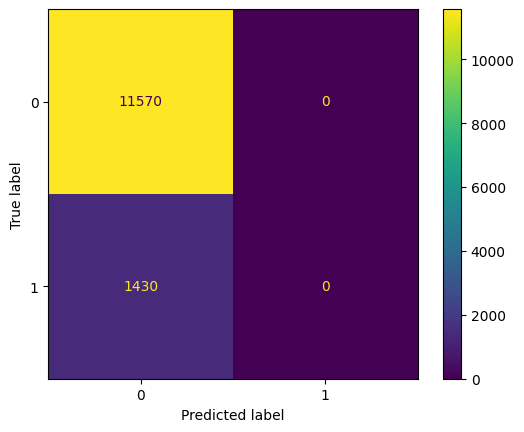

In [43]:
# Matriz de Confusão
confusion_matrix_modelo = confusion_matrix(y, y_pred, labels=lista_classe)
display = ConfusionMatrixDisplay(confusion_matrix_modelo, display_labels=lista_classe)
display.plot()

### Turning de Hiperparâmetros

Evitar o Overfitting
Buscar o Melhor Hiperparámetros

In [44]:
# min_sample_leaf = Mínimo de instâncias(registros ou objetos) requeridos para formar uma folha(nó terminal)
# max_depth = Profundidade máxima da árvore

def decisiontree_optuna(trial):

    min_samples_leaf = trial.suggest_int('min_samples_leaf', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 5)

    dt_model.set_params(classifier__min_samples_leaf=min_samples_leaf,
                        classifier__max_depth=max_depth,
                        classifier__class_weight='balanced')

    scores = cross_val_score(dt_model, X, y, cv=cv_folds, scoring='recall')

    return scores.mean()


In [45]:
# Executar a automação de experimentos
estudo_deciontree = optuna.create_study(direction='maximize')
estudo_deciontree.optimize(decisiontree_optuna, n_trials=100) # executar 100 vezes o paramentro da decisiontree_optuna

[I 2026-02-08 19:04:11,353] A new study created in memory with name: no-name-e584496e-b7c6-4555-bad0-07f3fba06493
[I 2026-02-08 19:04:11,535] Trial 0 finished with value: 0.4427150315052646 and parameters: {'min_samples_leaf': 97, 'max_depth': 2}. Best is trial 0 with value: 0.4427150315052646.
[I 2026-02-08 19:04:11,687] Trial 1 finished with value: 0.4427150315052646 and parameters: {'min_samples_leaf': 50, 'max_depth': 3}. Best is trial 0 with value: 0.4427150315052646.
[I 2026-02-08 19:04:11,837] Trial 2 finished with value: 0.4427150315052646 and parameters: {'min_samples_leaf': 342, 'max_depth': 3}. Best is trial 0 with value: 0.4427150315052646.
[I 2026-02-08 19:04:11,988] Trial 3 finished with value: 0.4427150315052646 and parameters: {'min_samples_leaf': 403, 'max_depth': 4}. Best is trial 0 with value: 0.4427150315052646.
[I 2026-02-08 19:04:12,138] Trial 4 finished with value: 0.4427150315052646 and parameters: {'min_samples_leaf': 456, 'max_depth': 5}. Best is trial 0 with 

In [46]:
print(f'Melhor Acurácia: {estudo_deciontree.best_value}')
print(f'Melhor Parâmetros: {estudo_deciontree.best_params}')

Melhor Acurácia: 0.4427150315052646
Melhor Parâmetros: {'min_samples_leaf': 97, 'max_depth': 2}


## Visualizar dados

In [47]:
X_train_treen = X.copy()
X_train_treen['tipo_transacao'] = X_train_treen['Tipo de Transacao'].astype('category').cat.codes
X_train_treen.head(10)

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Hora,escala_hora_Madrugada,escala_hora_Manhã,escala_hora_Tarde,escala_hora_Noite,tipo_transacao
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14T07:29:28.256579,7,0,1,0,0,3
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12T17:54:09.119410,17,0,0,1,0,3
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03T17:31:42.087599,17,0,0,1,0,2
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23T17:57:02.055680,17,0,0,1,0,2
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07T17:30:36.879557,17,0,0,1,0,2
5,cliente62C357,Débito,4848.49,7354.41,2505.92,2025-07-08T19:16:37.207970,19,0,0,0,1,1
6,cliente320C76,Crédito,1600.44,7296.87,5696.43,2024-09-07T02:23:16.975044,2,1,0,0,0,0
7,cliente32CB58,Crédito,1296.71,10562.92,9266.21,2023-08-28T23:09:19.817457,23,0,0,0,1,0
8,cliente67AFD9,Débito,1187.35,10935.18,9747.83,2024-05-21T09:01:08.163132,9,0,1,0,0,1
9,cliente84F77D,PIX,3271.51,3405.61,134.10,2022-09-26T10:33:12.415982,10,0,1,0,0,2


In [48]:
# Ajustes - remover colunas categoricas
X_train_treen['Hora'] = pd.to_datetime(X_train_treen['Horario da Transacao']).dt.hour
colunas_para_remover = ['Cliente', 'Tipo de Transacao', 'Horario da Transacao']
X_train_treen.drop(columns=colunas_para_remover, axis=1, inplace=True)
X_train_treen.head(10)

,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Hora,escala_hora_Madrugada,escala_hora_Manhã,escala_hora_Tarde,escala_hora_Noite,tipo_transacao
0,390.39,5446.75,5056.36,7,0,1,0,0,3
1,3272.03,12167.89,8895.86,17,0,0,1,0,3
2,4905.72,8217.63,3311.91,17,0,0,1,0,2
3,3073.23,7833.16,4759.93,17,0,0,1,0,2
4,4233.03,6920.82,2687.79,17,0,0,1,0,2
5,4848.49,7354.41,2505.92,19,0,0,0,1,1
6,1600.44,7296.87,5696.43,2,1,0,0,0,0
7,1296.71,10562.92,9266.21,23,0,0,0,1,0
8,1187.35,10935.18,9747.83,9,0,1,0,0,1
9,3271.51,3405.61,134.10,10,0,1,0,0,2


In [49]:
clf_decisiontree = DecisionTreeClassifier(min_samples_leaf=estudo_deciontree.best_params['min_samples_leaf'],
                                          max_depth=estudo_deciontree.best_params['max_depth'],
                                          class_weight='balanced')

y_train_tree = y.copy()

clf_decisiontree.fit(X_train_treen, y_train_tree)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,97
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [50]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(10,10), dpi=1200)

plot_tree(clf_decisiontree,
          feature_names=X_train_treen.columns.to_list(),
          class_names=['Normal', 'Fraude'],
          filled=True,
          max_depth=6)
plt.show()

## Salvar modelo

In [51]:
import joblib

dt_model_tunado = Pipeline(steps=[('prepocessor', pre_processor),
                                  ('classifier', DecisionTreeClassifier(
                                    min_samples_leaf=estudo_deciontree.best_params['min_samples_leaf'],
                                    max_depth=estudo_deciontree.best_params['max_depth'],
                                    class_weight='balanced'
                                    ))
                                  ])

dt_model_tunado.fit(X, y)

joblib.dump(dt_model_tunado, 'modelo_transacao_decision.pkl')

['modelo_transacao_decision.pkl']

### App de Predição Batch(por arquivo)

In [52]:
import gradio as gr
print(gr.__version__)

5.46.0


In [53]:
import gradio as gr

modelo = joblib.load('./modelo_transacao_decision.pkl')

def predict(arquivo):
    df_transacoes_file = pd.read_csv(arquivo.name)

    y_pred = modelo.predict(df_transacoes_file)

    df_transacoes_file['Previsao_Fraude'] = y_pred

    output_path = "predicoes_batch.csv"
    df_transacoes_file.to_csv(output_path, index=False)
    
    return output_path

demo = gr.Interface(
    fn=predict,
    inputs=gr.File(label="Upload CSV de Transações"),
    outputs=gr.File(label="Download das Predições"),
    title="Sistema de Detecção de Fraude - Batch"
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
